<a href="https://colab.research.google.com/github/Sam54000/vibro-tactile-P300-lockedIn-patient/blob/main/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scipy --upgrade

In [204]:
!pip install tsaug

In [ ]:
#!pip install pycausalimpact

In [1]:
import numpy as np
import pandas as pd
 
import os
import glob
 
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.collections as collections
 
import tensorflow as tf
import tensorflow.feature_column as fc
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
!pip install pyriemann
!pip install mne
import pyriemann
from sklearn.model_selection import cross_val_score

In [206]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Constants
EEG_CHANNELS = ["Fz", "C3", "Cz", "C4", "CP1", "CPz", "CP2", "Pz"]
dir = "/content/drive/MyDrive/Locked-In/Data"

Load Data

In [3]:
os.chdir(dir)
os.getcwd()

'/content/drive/MyDrive/Locked-In/Data'

In [4]:
mat_files = glob.glob('*.mat')
mat_files

['P1_high1.mat',
 'P2_low1.mat',
 'P2_high1.mat',
 'P2_high2.mat',
 'P2_low2.mat',
 'P1_high2.mat',
 'P1_low1.mat',
 'P1_low2.mat']

In [5]:
mat_file = spio.loadmat(mat_files[0])
keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
cleaned_mat_file = {i:mat_file[i] for i in mat_file if i in keys}
channel_data = pd.DataFrame(cleaned_mat_file["y"], columns=EEG_CHANNELS)
fs = pd.DataFrame(cleaned_mat_file["fs"])[0][0]
channel_data.head()
outputs = cleaned_mat_file["trig"]

In [6]:
eeg_recordings = {}
for mat_file_name in mat_files:
  mat_file = spio.loadmat(mat_file_name)
  keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
  cleaned_mat_file = {i:mat_file[i] for i in mat_file if i in keys}
  channel_data = pd.DataFrame(cleaned_mat_file["y"], columns=EEG_CHANNELS)
  channel_data["output"] = cleaned_mat_file["trig"]
  channel_data["output"] = channel_data["output"].replace([-1], 3)
  channel_data.astype({"output": "int32"})
  eeg_recordings[mat_file_name] = channel_data

Distractor - 3
Non target - 1
Target - 2

In [7]:
sample_data = eeg_recordings["P2_low2.mat"]
sample_data

,Fz,C3,Cz,C4,CP1,CPz,CP2,Pz,output
0,-18.198307,-41.679142,-58.040730,-28.957844,-45.758099,-39.229214,-49.859024,-24.768824,0
1,-20.113195,-42.527195,-59.256149,-30.186872,-47.145695,-40.757290,-51.395859,-25.748331,0
2,-21.264162,-42.744385,-59.901157,-31.081549,-48.150112,-42.143810,-52.995609,-26.235826,0
3,-21.481592,-42.307217,-60.127342,-31.577698,-48.578995,-43.137711,-54.385029,-26.291319,0
4,-20.914345,-41.543095,-60.199566,-31.790014,-48.486229,-43.609638,-55.377396,-26.268978,0
...,...,...,...,...,...,...,...,...,...
39899,-22.427023,-7.066786,-8.480715,-11.711740,-3.986313,-10.272511,-16.349691,-12.297679,0
39900,-21.098677,-6.132523,-7.287198,-10.273462,-3.388305,-9.055482,-14.875256,-10.983068,0
39901,-19.748150,-4.906825,-5.996058,-8.878644,-2.713736,-7.944721,-13.645805,-10.435642,0
39902,-18.376886,-3.759302,-4.738688,-7.595037,-1.934436,-7.085990,-12.773139,-10.569434,0


[0.00000000e+00 3.90625000e-03 7.81250000e-03 ... 1.55863281e+02
 1.55867188e+02 1.55871094e+02]


,Fz,C3,Cz,C4,CP1,CPz,CP2,Pz,output
0,-18.198307,-41.679142,-58.040730,-28.957844,-45.758099,-39.229214,-49.859024,-24.768824,0
1,-20.113195,-42.527195,-59.256149,-30.186872,-47.145695,-40.757290,-51.395859,-25.748331,0
2,-21.264162,-42.744385,-59.901157,-31.081549,-48.150112,-42.143810,-52.995609,-26.235826,0
3,-21.481592,-42.307217,-60.127342,-31.577698,-48.578995,-43.137711,-54.385029,-26.291319,0
4,-20.914345,-41.543095,-60.199566,-31.790014,-48.486229,-43.609638,-55.377396,-26.268978,0
...,...,...,...,...,...,...,...,...,...
39899,-22.427023,-7.066786,-8.480715,-11.711740,-3.986313,-10.272511,-16.349691,-12.297679,0
39900,-21.098677,-6.132523,-7.287198,-10.273462,-3.388305,-9.055482,-14.875256,-10.983068,0
39901,-19.748150,-4.906825,-5.996058,-8.878644,-2.713736,-7.944721,-13.645805,-10.435642,0
39902,-18.376886,-3.759302,-4.738688,-7.595037,-1.934436,-7.085990,-12.773139,-10.569434,0


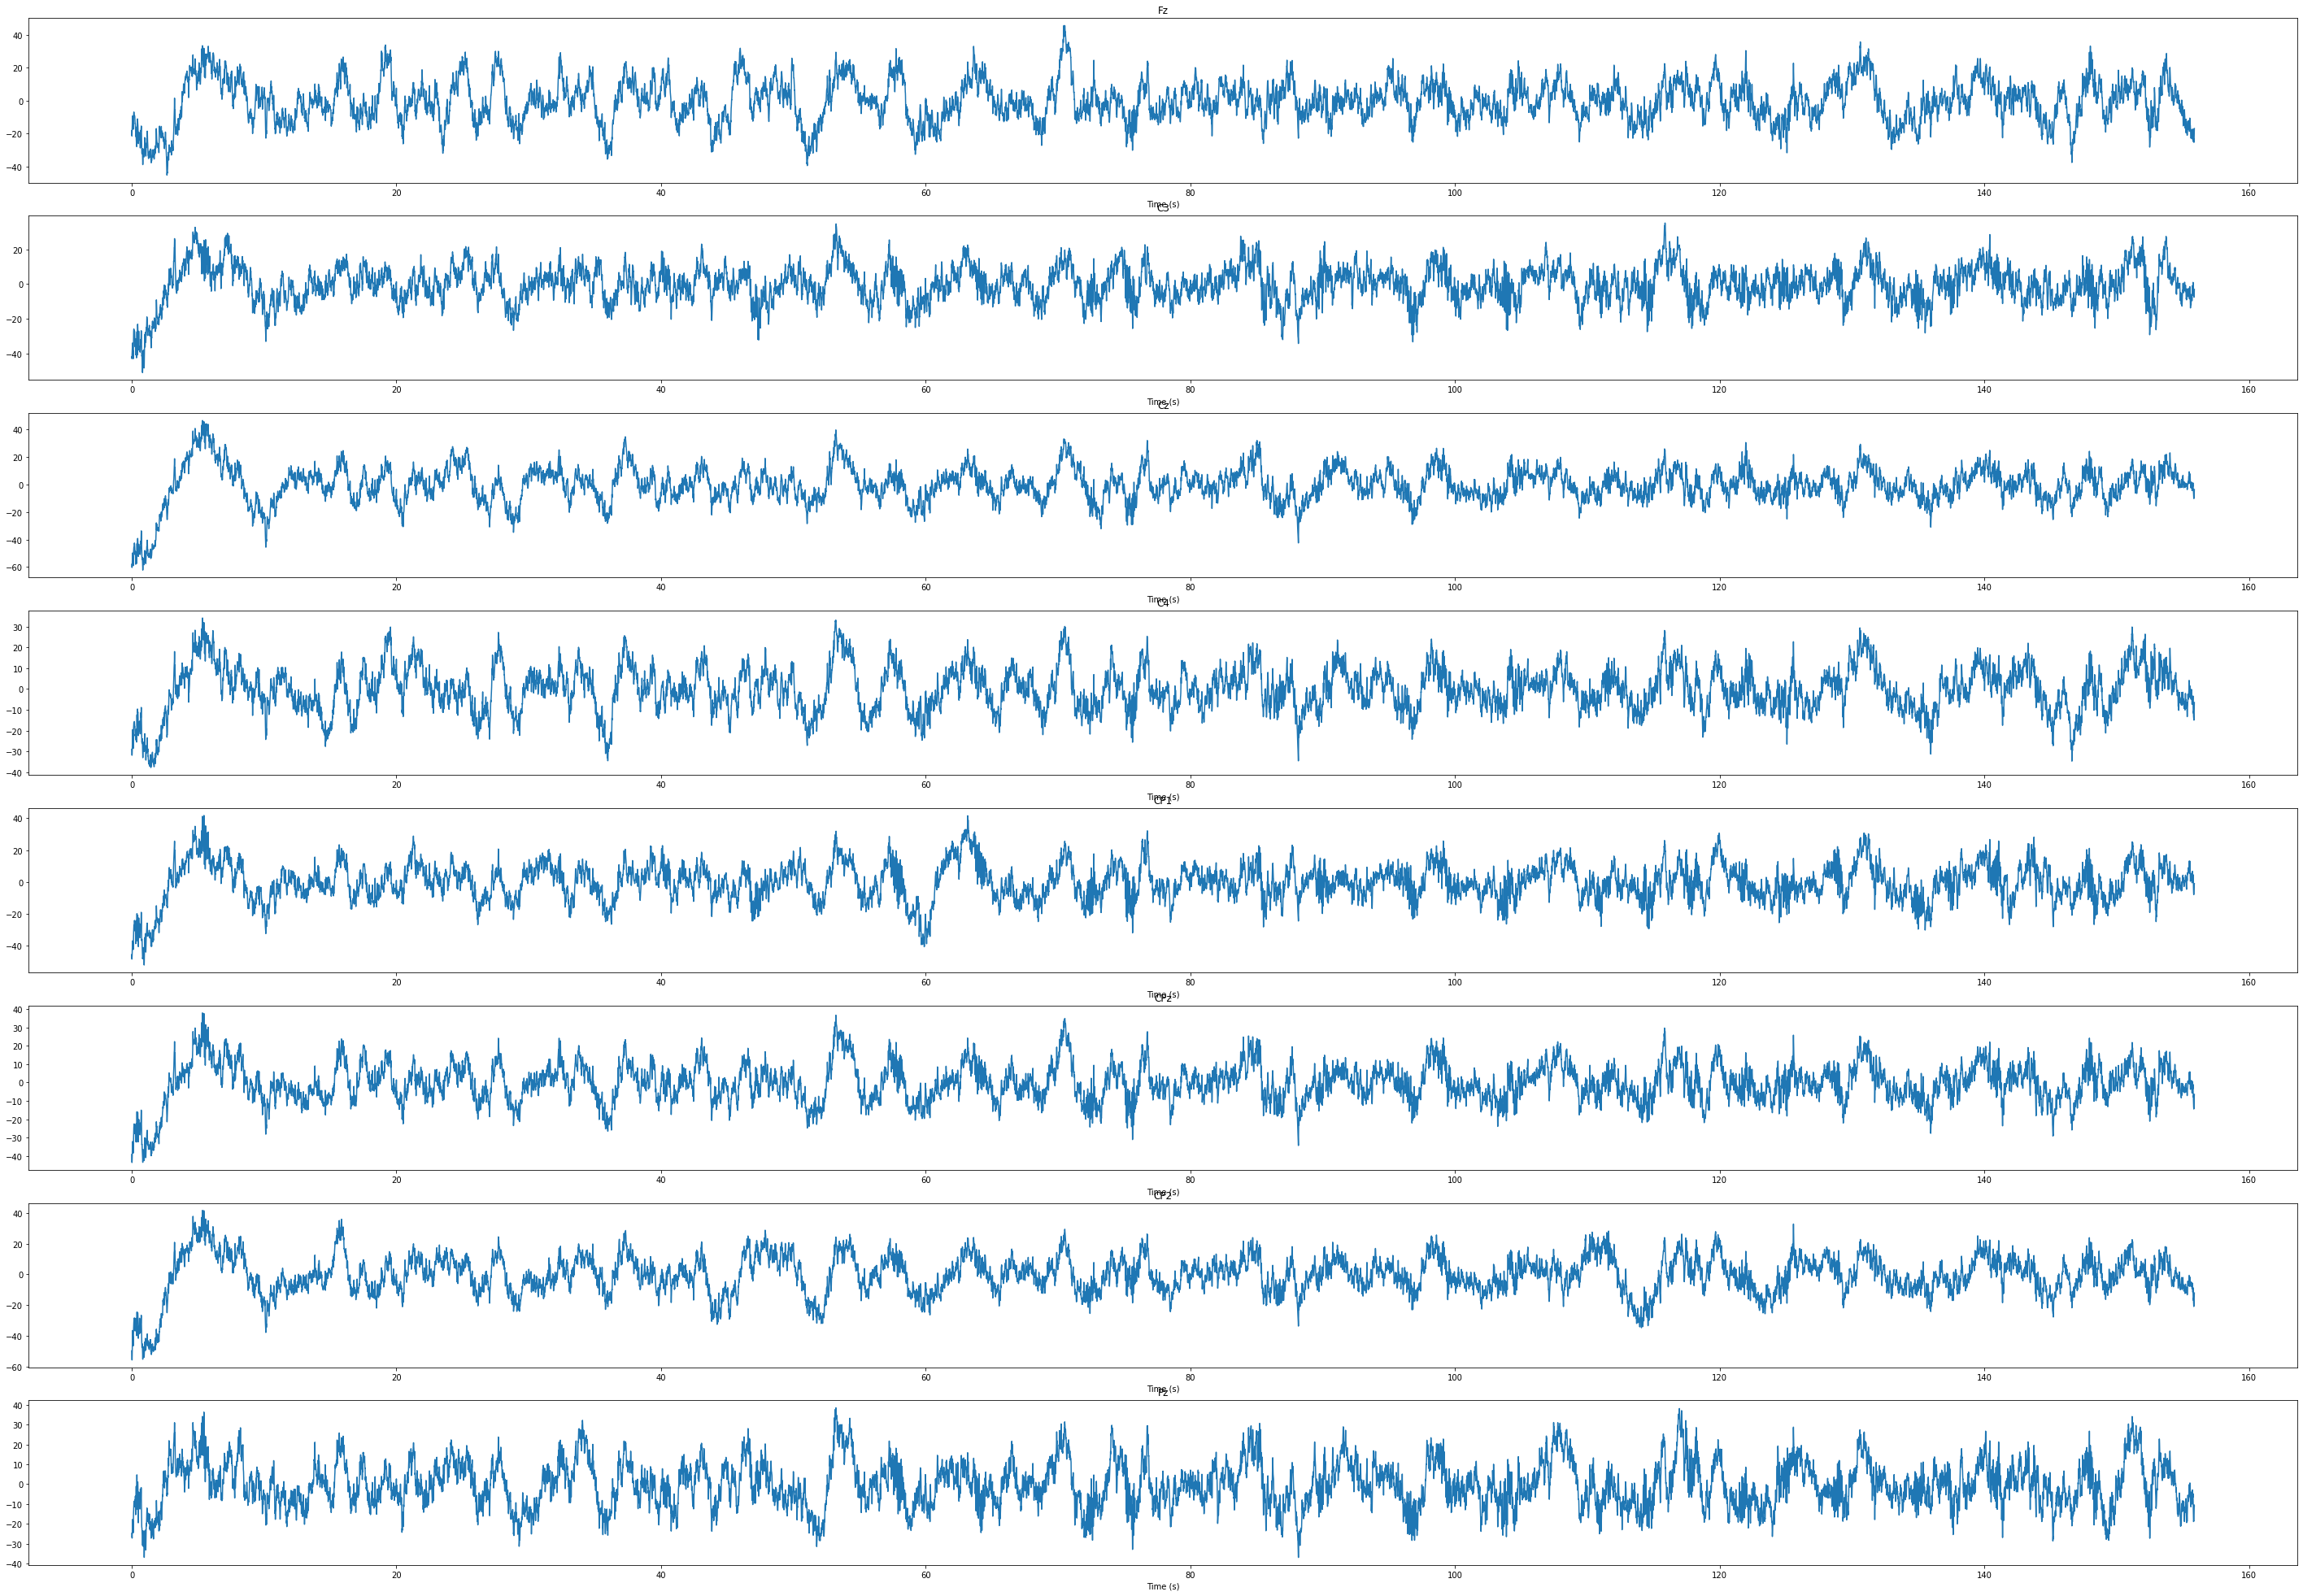

In [8]:
nrows = 8
ncols = 1
t = np.arange(0,sample_data['CP1'].shape[0]/fs,1/fs)
print(t)
fig, ax = plt.subplots(nrows, figsize=(50,35))
counter = 0
display(sample_data)
for i in range(8):
  try:
    channel = EEG_CHANNELS[counter]
    counter = counter + 1 
    ax[i].plot(t,sample_data[channel])
    ax[i].set_title(channel)   
    ax[i].set_xlabel("Time (s)")   
  except:
    continue

Power Spectrum

Text(0.5, 1.0, 'Power spectrum (np.fft.fft)')

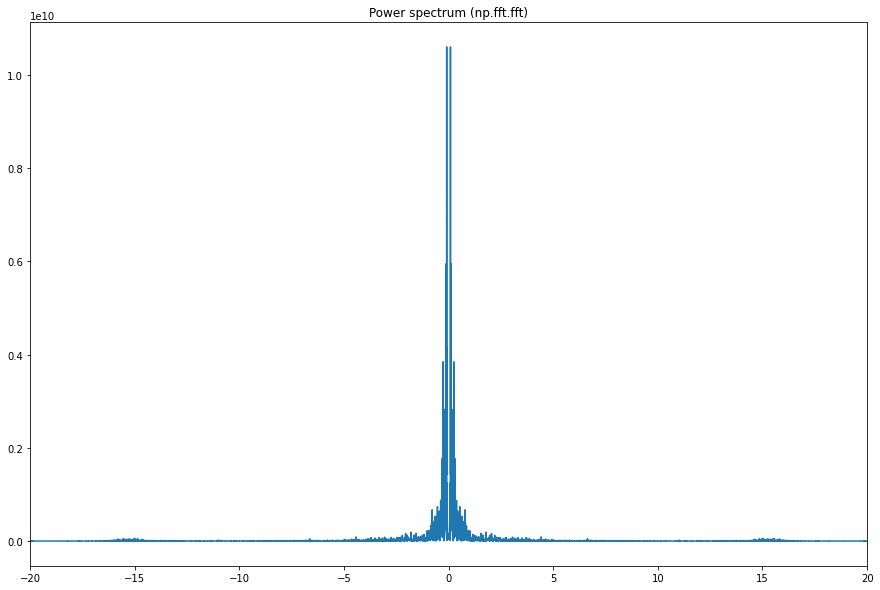

In [9]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# np.fft.fft
freqs = np.fft.fftfreq(t.size, 1/fs)
idx = np.argsort(freqs)
x = sample_data['CP1']
ps = np.abs(np.fft.fft(x))**2
plt.figure(figsize=(15,10))
plt.plot(freqs[idx], ps[idx])
plt.xlim(-20,20)
plt.title('Power spectrum (np.fft.fft)')

Text(0.5, 1.0, 'Power spectrum (np.fft.fft)')

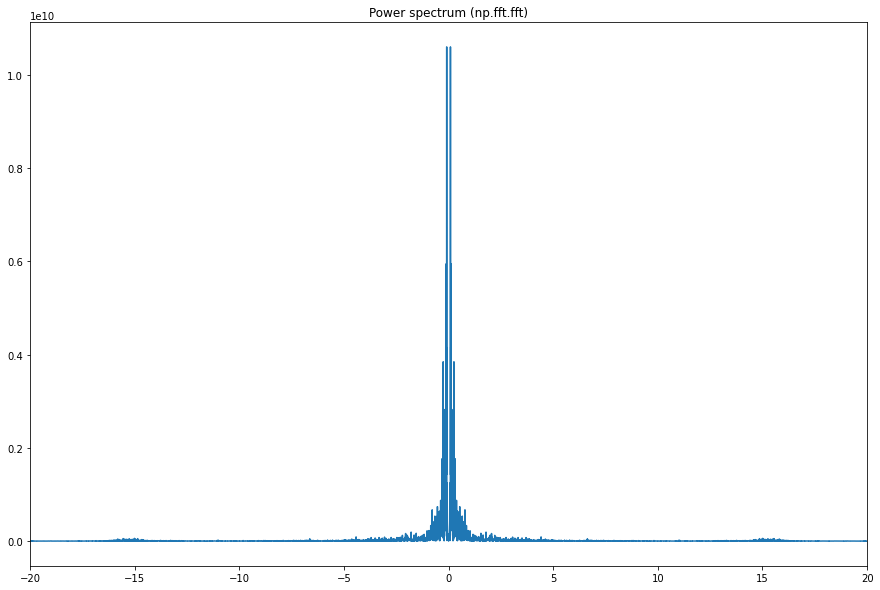

In [10]:
freqs = np.fft.fftfreq(t.size, 1/fs)
idx = np.argsort(freqs)
x = sample_data['CP1'] 
x = x - np.mean(x)
ps = np.abs(np.fft.fft(x))**2
plt.figure(figsize=(15,10))
plt.plot(freqs[idx], ps[idx])
plt.xlim(-20,20)
plt.title('Power spectrum (np.fft.fft)')

In [11]:
sample_data.output.value_counts()

0    39424
3      360
1       60
2       60
Name: output, dtype: int64

In [ ]:
t.size

39904

In [12]:
All_channels = np.zeros((8,t.size))
for i, ch in enumerate(EEG_CHANNELS):
  All_channels[i,:] = sample_data[ch]

(<Figure size 1152x1152 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f423a657450>,
       dtype=object))

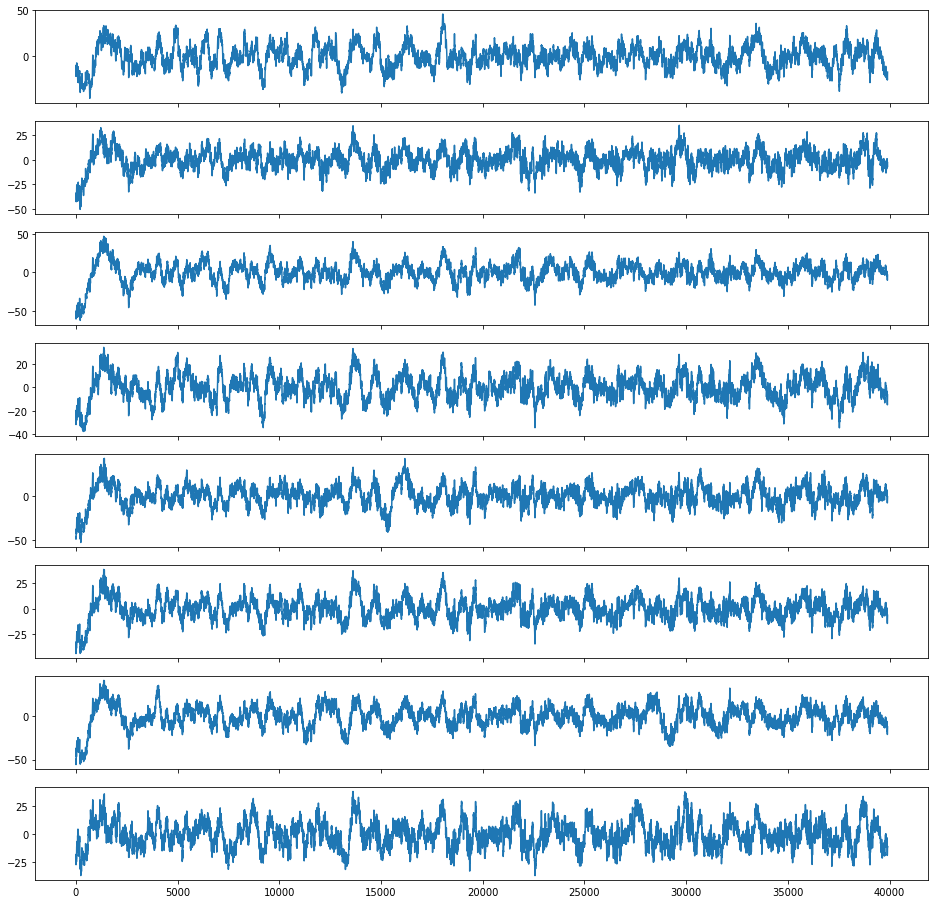

In [13]:
from tsaug.visualization import plot
plot(All_channels)

Segment

In [14]:
# Initialize dict of dict
segmented_data_dict = {**dict.fromkeys(mat_files, {})}
augmented_data_dict = {**dict.fromkeys(mat_files, {})}
for mat_file in mat_files[0:]:
  df = eeg_recordings[mat_file]
  
  n_ch, n_sample = 8, 180
  n_output = len(df[df.output !=0])

  #output a segmented matrix  (number of segments x segment length x channels) for a mat file
  All_segs = np.empty((n_output, 180, 8))

  #initilaize y with length equal total no. of valid output 1,2,3
  y = np.zeros(n_output)

  prev_y = 0
  for output in [1,2,3]:
    
    output_df = df[df.output == output]
    n = len(output_df)

    # create x
    for i, sample_idx in enumerate(output_df.index.values):
      # print(sample_idx)
      # each segment is -100ms to 600ms (128 x 8 )
      #.loc end-index is inclusive, we want the sample right before 600ms mark
      segment = df.drop("output", axis=1).loc[sample_idx-26:
                                                sample_idx+153, :].to_numpy()
      # print(segment.shape)     
      # print(All_segs.shape)                                     
      All_segs[prev_y + i,] = segment

    # create y
    y[prev_y:
      prev_y + n] = output
    prev_y = prev_y + n
    # print(y)

  #save X,y as a dict of dict {matfile1: {X: arr, y: arr}, 
  segmented_data_dict[mat_file] = {
      "X": All_segs,
      "y": y
  }
  augmented_data_dict[mat_file] = {
       "X": All_segs,
      "y": y
  }
  print(mat_file)
  print(segmented_data_dict[mat_file]['X'].shape)
  print(segmented_data_dict[mat_file]['y'].shape)
  print("---")
  # break

P1_high1.mat
(480, 180, 8)
(480,)
---
P2_low1.mat
(480, 180, 8)
(480,)
---
P2_high1.mat
(480, 180, 8)
(480,)
---
P2_high2.mat
(480, 180, 8)
(480,)
---
P2_low2.mat
(480, 180, 8)
(480,)
---
P1_high2.mat
(480, 180, 8)
(480,)
---
P1_low1.mat
(480, 180, 8)
(480,)
---
P1_low2.mat
(480, 180, 8)
(480,)
---


Data Augmentation

In [15]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise
my_augmenter = (
    # random time warping 5 times in parallel
       Drift(max_drift=(0.1, 0.2)) @ 0.2  # with 80% probability, random drift the signal up to 10% - 50%
     + Reverse() @ 0.5  # with 50% probability, reverse the sequence
     + AddNoise(scale=(0.01, 0.05)) @ 0.5  
 )

In [16]:
for i in range(5):
  for mat_file in mat_files[0:]:
    aug_data = 0
    new_labels = 0
    ind = ((segmented_data_dict[mat_file]['y'] == 1) | (segmented_data_dict[mat_file]['y'] == 2))
    req_data = segmented_data_dict[mat_file]['X'][ind]
    req_data = np.swapaxes(req_data, 2, 1)
    new_labels = segmented_data_dict[mat_file]['y'][ind]
    aug_data = my_augmenter.augment(req_data)
    aug_data = np.swapaxes(aug_data,1,2)
    augmented_data_dict[mat_file]['X'] = np.vstack((augmented_data_dict[mat_file]['X'], aug_data))
    augmented_data_dict[mat_file]['y'] = np.hstack((augmented_data_dict[mat_file]['y'], new_labels))

In [17]:
augmented_data_dict['P1_high1.mat']['X'].shape

(1080, 180, 8)

(<Figure size 1152x1152 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f423ada09d0>,
       dtype=object))

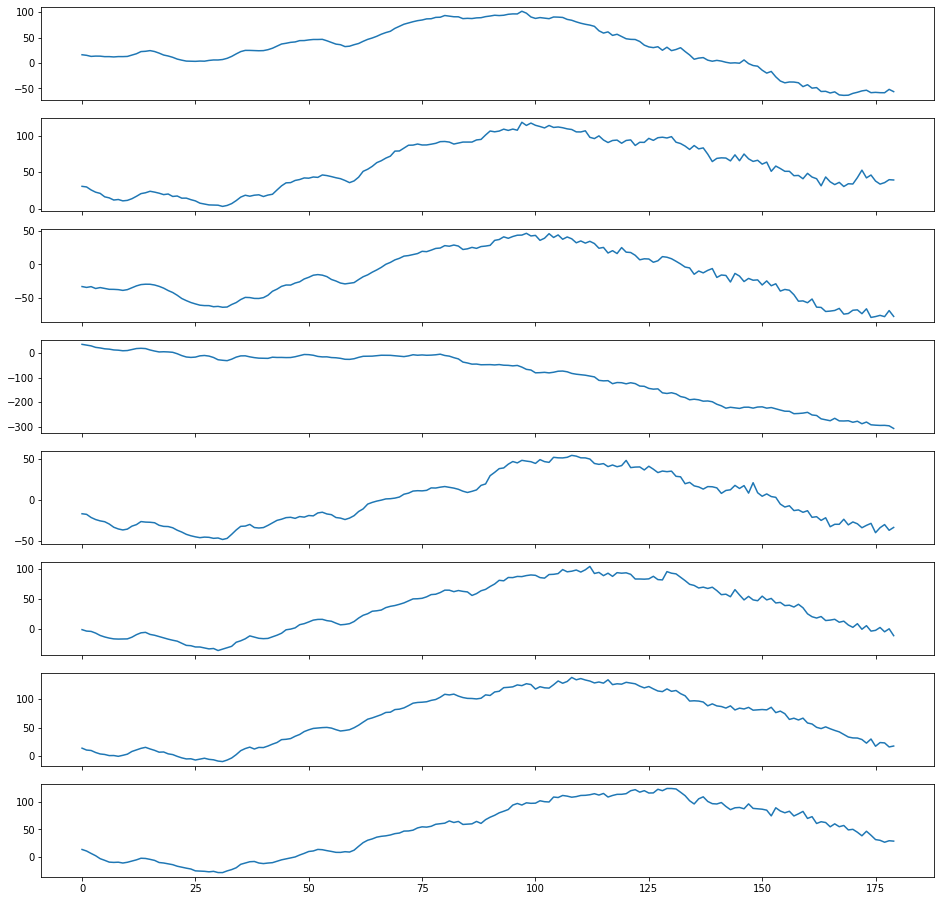

In [18]:
plot(np.swapaxes(augmented_data_dict['P1_high1.mat']['X'][-5],0,1))

In [19]:
P1_X = np.empty((1,180,8))
P1_Y = np.empty((1,))
for mat_file in ["P1_high1.mat","P1_low1.mat"]:
  X = augmented_data_dict[mat_file]['X']
  y = augmented_data_dict[mat_file]['y']
  P1_X = np.vstack((P1_X, X))
  P1_Y =  np.hstack((P1_Y,y))
P1_X = P1_X[1:,:,:]
P1_Y = P1_Y[1:]

In [20]:
P1_X.shape

(2160, 180, 8)

In [21]:
for i in range(P1_X.shape[0]):
  P1_X[i,:,:] = P1_X[i,:,:] - np.average(P1_X[i,0:26,:],axis=0)

Plot Random Signal Windows

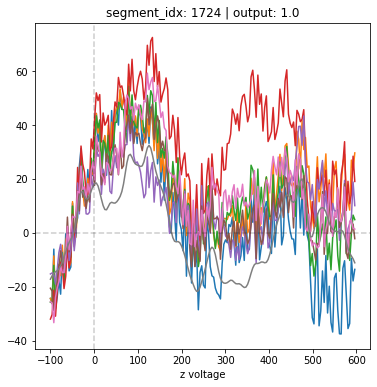

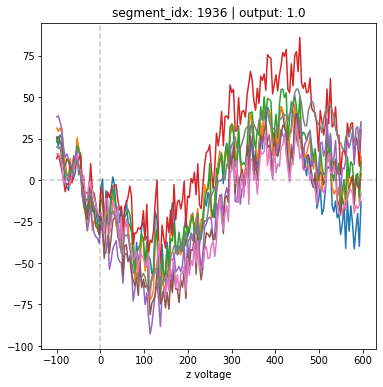

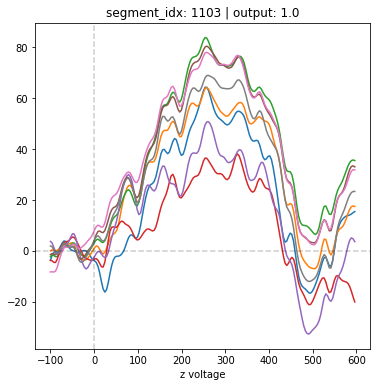

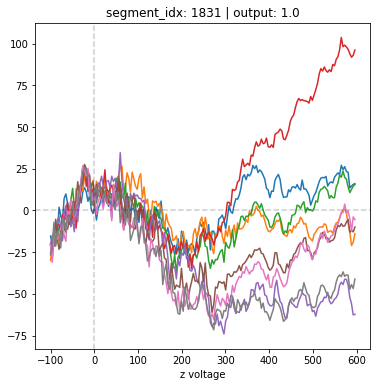

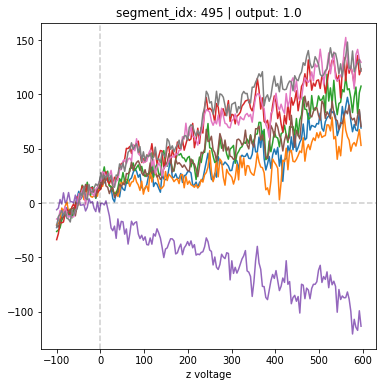

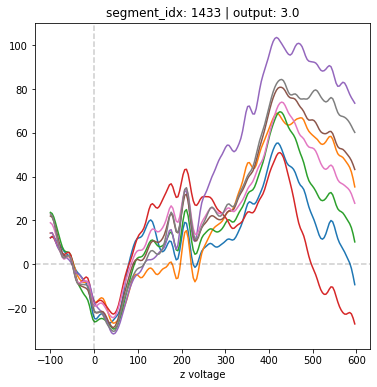

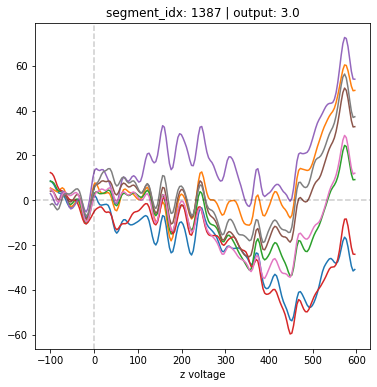

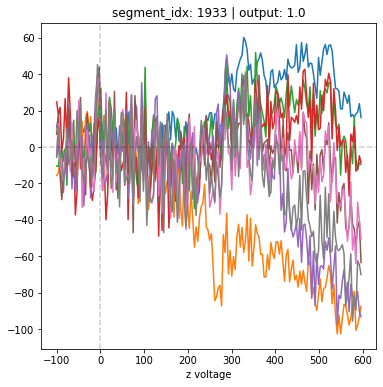

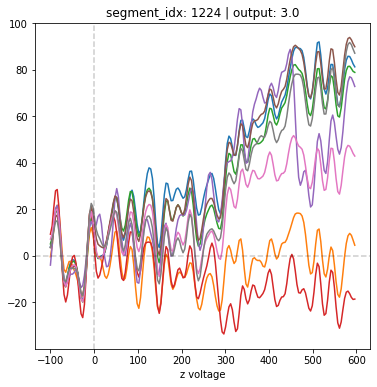

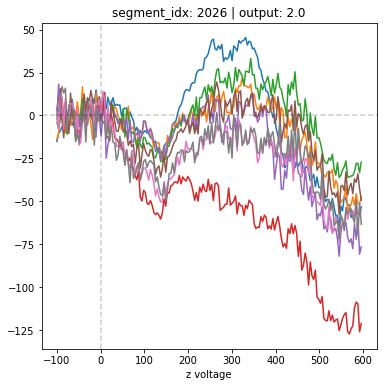

In [22]:
import random
x_plot_arr = P1_X #np.concatenate([X_train, X_test], axis=0)
for _ in range(10):
  seg = random.choice(np.arange(len(x_plot_arr)))
  output = P1_Y[seg]

  plt.figure(figsize=(6,6))
  for i in x_plot_arr[seg,:,:].T:
    # print(i.shape)
    #26 samples: 100s
    plt.plot(np.arange(-100, 600, 700/180), i)
  plt.axvline(0, c='k', alpha=0.2, linestyle="--")
  plt.axhline(0, c='k', alpha=0.2, linestyle="--")
  plt.title("segment_idx: {} | output: {}".format(seg, output))
  plt.xlabel('ms')
  plt.xlabel('z voltage')

Plot Class Average

(180, 8)
(180, 8)
(180, 8)


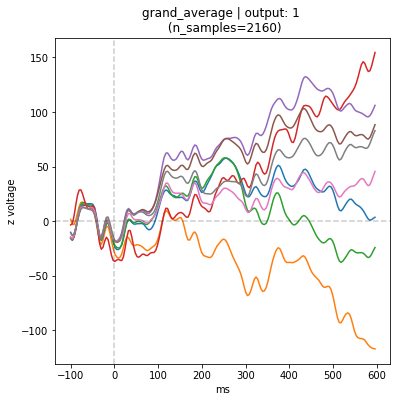

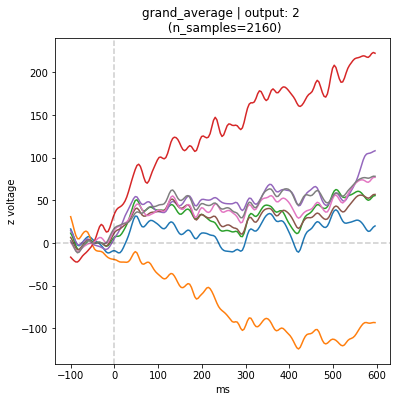

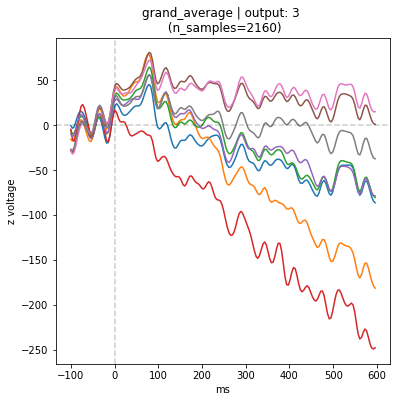

In [23]:
x_plot_arr, y_plot_arr = P1_X, P1_Y
for output in [1, 2,3]:
  X_average = np.average(x_plot_arr[np.argwhere(y_plot_arr==output)][0], axis=0)
  print(X_average.shape)
  seg = "grand_average"
  plt.figure(figsize=(6,6))
    #26 samples: 100s
  for ch in np.arange(8):
    plt.plot(np.arange(-100, 600, 700/180), X_average.T[ch])
  plt.axvline(0, c='k', alpha=0.2, linestyle="--")
  plt.axhline(0, c='k', alpha=0.2, linestyle="--")
  plt.title("{} | output: {} \n (n_samples={})".format(seg, output, len(x_plot_arr)))
  plt.xlabel('ms')
  plt.ylabel('z voltage')

Significance Test

In [67]:
x1 = segmented_data_dict['P1_high1.mat']['X'][2]
x2 = segmented_data_dict['P1_high1.mat']['X'][62]
x3 = segmented_data_dict['P1_high1.mat']['X'][122]

In [71]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(x1[0], x2[0], method="exact")

In [68]:
win = 30
overalp = 20
pvals = []
I = []
for i in range(0,180-win-1,10):
  I.append(i)
  seg1 = x1[i:i+win,0]
  seg2 = x2[i:i+win,0]
  _, p = mannwhitneyu(seg1, seg2, method="exact")
  pvals.append(p)


In [69]:
sig = [i*10 for i,j in enumerate(pvals) if j <= 0.05 ]
sig

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

Text(0, 0.5, 'z voltage')

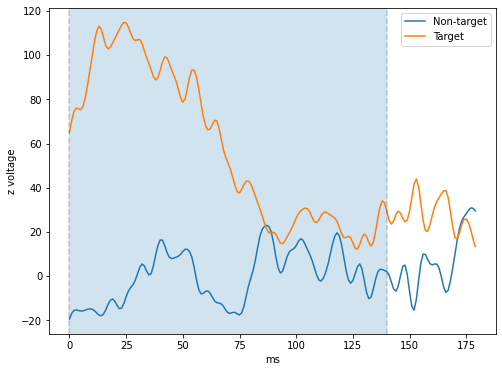

In [95]:
time = np.arange(0,180)
plt.figure(figsize=(8,6))
plt.plot(time,x1[:,0])
plt.plot(time,x2[:,0])
# plt.plot(x3[:,0])

plt.axvline(0, c='k', alpha=0.2, linestyle="--")
plt.axvline(140, c='k', alpha=0.2, linestyle="--")
# plt.axvline(120, c='k', alpha=0.2, linestyle="--")
# plt.axvline(140, c='k', alpha=0.2, linestyle="--")
plt.legend(['Non-target', 'Target',])
# plt.title("{} | output: {} \n (n_samples={})".format(seg, output, len(x_plot_arr)))
plt.xlabel('ms')
plt.axvspan(0, 140, alpha=0.2)
plt.ylabel('z voltage')

In [78]:
win = 30
overalp = 20
pvals = []
I = []
for i in range(0,180-win-1,10):
  I.append(i)
  seg1 = x1[i:i+win,0]
  seg2 = x3[i:i+win,0]
  _, p = mannwhitneyu(seg1, seg2, method="exact")
  pvals.append(p)


In [79]:
sig = [i*10 for i,j in enumerate(pvals) if j <= 0.05 ]
sig

[0, 10, 40, 50, 70, 80, 90, 100, 130, 140]

Text(0, 0.5, 'z voltage')

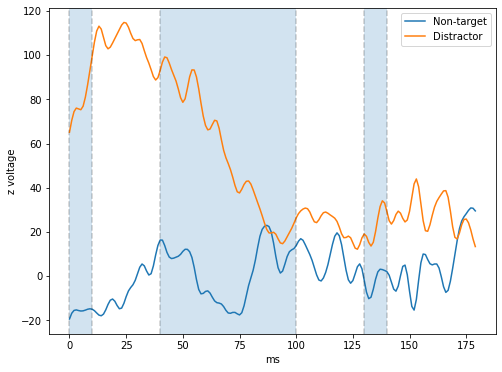

In [96]:
plt.figure(figsize=(8,6))
plt.plot(x1[:,0])
plt.plot(x2[:,0])
# plt.plot(x3[:,0])

plt.axvline(0, c='k', alpha=0.2, linestyle="--")
plt.axvline(10, c='k', alpha=0.2, linestyle="--")
plt.axvline(40, c='k', alpha=0.2, linestyle="--")
plt.axvline(100, c='k', alpha=0.2, linestyle="--")
plt.axvline(130, c='k', alpha=0.2, linestyle="--")
plt.axvline(140, c='k', alpha=0.2, linestyle="--")
plt.legend(['Non-target', 'Distractor',])
# plt.title("{} | output: {} \n (n_samples={})".format(seg, output, len(x_plot_arr)))
plt.axvspan(0, 10, alpha=0.2)
plt.axvspan(40, 100, alpha=0.2)
plt.axvspan(130, 140, alpha=0.2)
plt.xlabel('ms')
plt.ylabel('z voltage')